# Get the data for single who wants to move to Austin

#### This is on assumption that he/she is looking for shopping nightlide and apartments

In [1]:
#define the Headers 
import folium
import pandas as pd
import numpy as np
import vincent
import matplotlib.pyplot as plt

In [2]:
# Create the Data frame from night life and apartment
nightlife_df = pd.read_csv('data_sources/nightlife_data_combined_with_cords.csv')
apt_df = pd.read_csv('data_sources/Atx_apartment.csv')

nightlife_df = nightlife_df.drop(['Unnamed: 0'], axis=1)
apt_df = apt_df.drop(['Unnamed: 0'], axis=1)

nightlife_df.head()

,ZipCode,Restaurant Count,Restaurant Rating,Bar Count,Bar Rating,Club Count,Club Rating,Lat,Lon,Bar/Restaurant Count,Bar/Restaurant Rating,Total Nightlife Count,Combined Rating
0,73301,3.0,4.500000,0.0,0.000000,0.0,0.000000,30.220098,-97.749046,3.0,9.000000,3.0,9.000000
1,78617,1.0,4.000000,2.0,3.000000,0.0,0.000000,30.201016,-97.665245,3.0,6.666667,3.0,6.666667
2,78646,2.0,4.500000,0.0,0.000000,0.0,0.000000,30.273205,-97.800709,2.0,9.000000,2.0,9.000000
3,78660,4.0,3.125000,2.0,3.000000,0.0,0.000000,30.453564,-97.666576,6.0,6.166667,6.0,6.166667
4,78701,201.0,4.186567,194.0,4.265464,223.0,3.376682,30.267238,-97.741325,618.0,5.401294,618.0,7.838188


In [3]:
apt_df.head()

,apartment Name,Zip code,Rating,latitude,longitude
0,Polaris on the Park,78741,4.5,30.220450,-97.744565
1,Easton Hills Apartments,78741,4.5,30.234663,-97.731773
2,The Oaks,78704,4.5,30.236873,-97.757093
3,First Call Properties,78745,4.5,30.229017,-97.788482
4,Montecito,78741,2.0,30.223560,-97.741970


In [4]:
nightlife_df = nightlife_df.drop(['Club Count', 'Club Rating', "Total Nightlife Count", 'Combined Rating' ], axis=1)


In [5]:
nightlife_df.rename(columns={'Bar/Restaurant Count': 'Nightlife Count', 'Bar/Restaurant Rating': 'Nightlife Rating'}, inplace=True)

nightlife_df.head()

,ZipCode,Restaurant Count,Restaurant Rating,Bar Count,Bar Rating,Lat,Lon,Nightlife Count,Nightlife Rating
0,73301,3.0,4.500000,0.0,0.000000,30.220098,-97.749046,3.0,9.000000
1,78617,1.0,4.000000,2.0,3.000000,30.201016,-97.665245,3.0,6.666667
2,78646,2.0,4.500000,0.0,0.000000,30.273205,-97.800709,2.0,9.000000
3,78660,4.0,3.125000,2.0,3.000000,30.453564,-97.666576,6.0,6.166667
4,78701,201.0,4.186567,194.0,4.265464,30.267238,-97.741325,618.0,5.401294


In [7]:
count_df = pd.DataFrame(apt_df.groupby('Zip code').count()['apartment Name'])
aparments_df = pd.DataFrame(apt_df.groupby('Zip code').mean()['Rating'])
aparments_df['Apartment count']  = count_df['apartment Name']
aparments_df.rename(columns={"Rating": "apartment Rating"}, inplace=True)
aparments_df.head()

,apartment Rating,Apartment count
Zip code,,
78613,5.000000,1
78701,4.322034,118
78702,4.234375,96
78703,3.857143,49
78704,4.110390,77


### Merge the Data

In [8]:
df_single = pd.merge(nightlife_df, aparments_df, left_on='ZipCode', right_index=True, how='left' ).replace(np.nan, 0)
#df_school_house[list(["Zipcode", "homesalecount", 'gsRating'])] = df_school_house[list(["Zipcode",  "homesalecount", 'gsRating'])].astype(int)
df_single.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
ZipCode              51 non-null int64
Restaurant Count     51 non-null float64
Restaurant Rating    51 non-null float64
Bar Count            51 non-null float64
Bar Rating           51 non-null float64
Lat                  51 non-null float64
Lon                  51 non-null float64
Nightlife Count      51 non-null float64
Nightlife Rating     51 non-null float64
apartment Rating     51 non-null float64
Apartment count      51 non-null float64
dtypes: float64(10), int64(1)
memory usage: 4.5 KB


## Plot the map

In [9]:
def Plotmarkers(mp, df):
    index = ['Restaurants', 'Bars', 'Apartment']
    
    for i, row in df.iterrows():
        #get the bars that needs to be plotted 
        data = {}
        #Generalize the rating to base 10
        data['Rating'] = [df.loc[i]['Restaurant Rating']*2, df.loc[i]['Bar Rating']*2,
                          df.loc[i]['apartment Rating']*2] 
        
        #Convert the dict into DataFrame
        df_bar = pd.DataFrame(data, index=index)
        
        #Plot a Barchart
        bar_chart = vincent.GroupedBar(df_bar, width=100, height=100 )
        
        #define color x and y axis 
        bar_chart.colors(range_= [ '#8856a7'])        
        x = df.loc[i]["ZipCode"]
        bar_chart.axis_titles(x="Night Life", y='Ratings')
        
        #tilt the y axis
        ax = vincent.AxisProperties(labels = vincent.PropertySet(angle=vincent.ValueRef(value=-45)))
        bar_chart.axes[0].properties = ax
        
        #create a pop up
        popup = folium.Popup()
        folium.Vega(bar_chart, height=150, width=200).add_to(popup)
        #add to the marker
        folium.Marker([df.loc[i]['Lat'], df.loc[i]['Lon']], popup=popup,
                 tooltip=df.loc[i]["ZipCode"].astype(int)).add_to(mp) 

    return mp

In [10]:
def Plotmap(mp, df):
    
    # Add marker one by one on the map
    for i, row in df.iterrows():
        #print(f"index {i}")
        folium.Circle(
            location=[df.loc[i]['Lat'], df.loc[i]['Lon']],
            popup=str(df.loc[i]['ZipCode']),
            radius=(df.loc[i]['Nightlife Count']+df.loc[i]['Apartment count'])*5,
            color='crimson',
            fill=True,
            fill_color='crimson'
        ).add_to(mp)  
        
    Plotmarkers(mp, df)
    return mp 
#Plotmap(nightlife_df)


## Call the functions to plot the graph

In [11]:
#define Austin map Lat Lon[30.35, -97.75]
mp = folium.Map(location=[30.35, -97.75], zoom_start=11)

#choice could be anything for this notebook it is only Nightlife
choice = 'Nightlife'
if choice == 'Nightlife':
    Plotmap(mp, df_single)
else:
    print("Nightlife")
    
mp.save('SingleChart.html')
mp
    

# Our Top 5 suggesions 

In [12]:
df_single.head()

,ZipCode,Restaurant Count,Restaurant Rating,Bar Count,Bar Rating,Lat,Lon,Nightlife Count,Nightlife Rating,apartment Rating,Apartment count
0,73301,3.0,4.500000,0.0,0.000000,30.220098,-97.749046,3.0,9.000000,0.000000,0.0
1,78617,1.0,4.000000,2.0,3.000000,30.201016,-97.665245,3.0,6.666667,0.000000,0.0
2,78646,2.0,4.500000,0.0,0.000000,30.273205,-97.800709,2.0,9.000000,0.000000,0.0
3,78660,4.0,3.125000,2.0,3.000000,30.453564,-97.666576,6.0,6.166667,0.000000,0.0
4,78701,201.0,4.186567,194.0,4.265464,30.267238,-97.741325,618.0,5.401294,4.322034,118.0


In [13]:
df= df_single.loc[df_single["Nightlife Count"]>=127]
df = df.head()
df

,ZipCode,Restaurant Count,Restaurant Rating,Bar Count,Bar Rating,Lat,Lon,Nightlife Count,Nightlife Rating,apartment Rating,Apartment count
4,78701,201.0,4.186567,194.0,4.265464,30.267238,-97.741325,618.0,5.401294,4.322034,118.0
5,78702,99.0,4.368687,106.0,4.367925,30.265720,-97.721989,219.0,8.178082,4.234375,96.0
8,78705,139.0,4.388489,142.0,3.742958,30.287830,-97.748200,296.0,7.712838,3.844037,218.0
41,78756,93.0,4.225806,59.0,3.940678,30.316296,-97.740876,152.0,8.230263,3.851852,27.0
43,78758,68.0,4.161765,53.0,3.650943,30.397838,-97.721562,127.0,7.503937,2.878571,70.0


### Add crime data

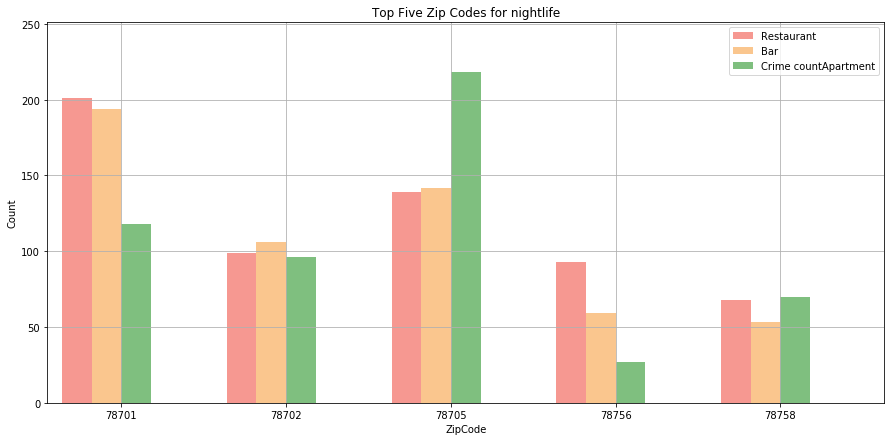

In [14]:
zipcode=[]
pos =  list(range(len(df['Bar Count']))) 
width = 0.18 
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(15,7))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['Restaurant Count'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=df.iloc[0]['ZipCode']) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['Bar Count'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=df.iloc[1]['ZipCode']) 

# Create a bar with post_score data,
# in position pos + some width buffer,
#plt.bar([p + width*2 for p in pos], 
#        #using df['post_score'] data,
#        df['crime count'], 
#        # of width
#        width, 
#        # with alpha 0.5
#        alpha=0.5, 
#        # with color
#        color='#FFC222', 
#        # with label the third value in first_name
#        label=df['ZipCode'][2])

plt.bar([p + width*2 for p in pos],
        #using df['pre_score'] data,
        df['Apartment count'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='green', 
        # with label the first value in first_name
        label=df.iloc[2]['ZipCode']) 
 

# Set the y axis label
ax.set_ylabel('Count')
ax.set_xlabel('ZipCode')

# Set the chart's title
ax.set_title('Top Five Zip Codes for nightlife')

# Set the position of the x ticks
ax.set_xticks([p +1.5* width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['ZipCode'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*5)
plt.ylim([0, max(df['Restaurant Count']+50)] )

# Adding the legend and showing the plot
plt.legend(['Restaurant', 'Bar', 'Crime count' 'Apartment'], loc='best')
plt.grid()
fig.savefig('Images/Top Five zip Code for nightlife.png')
plt.show()